# Laws Textures test

In [1]:
from feature_maps import laws_textures
import cv2, matplotlib.pyplot as plt, os, numpy as np

LABELS_DIR = "dtd/labels"
IMGS_DIR = "dtd/images"

def load_labels():
    out = {}
    with open(os.path.join(LABELS_DIR,"labels_joint_anno.txt"), "r") as f:
        line = f.readline()[:-1]
        while line:
            line         = line.split(" ")
            name, labels = line[0], line[1:]
            out[name]    = labels
            line         = f.readline()[:-1]
    return out

def load_set(labels, set_name = "train", N = 1000000):
    out = {}
    i = 0
    for s in [r for r in os.listdir(LABELS_DIR) if r.startswith("train")]:
        with open(os.path.join(LABELS_DIR,s), "r") as f:
            line = f.readline()[:-1]
            while line:
                img = cv2.imread(os.path.join(IMGS_DIR,line), cv2.IMREAD_GRAYSCALE)
                out[line] = {}
                out[line]["image"] = img
                out[line]["label"] = labels[line]
                line = f.readline()[:-1]
        i += 1
        if i == N:
            break
    return out

## Load datasets

In [2]:
labes = load_labels()
trainset = load_set(labes, "train", N = 1)

## Plot textures

In [3]:
laws = laws_textures(vector_dims = 5)

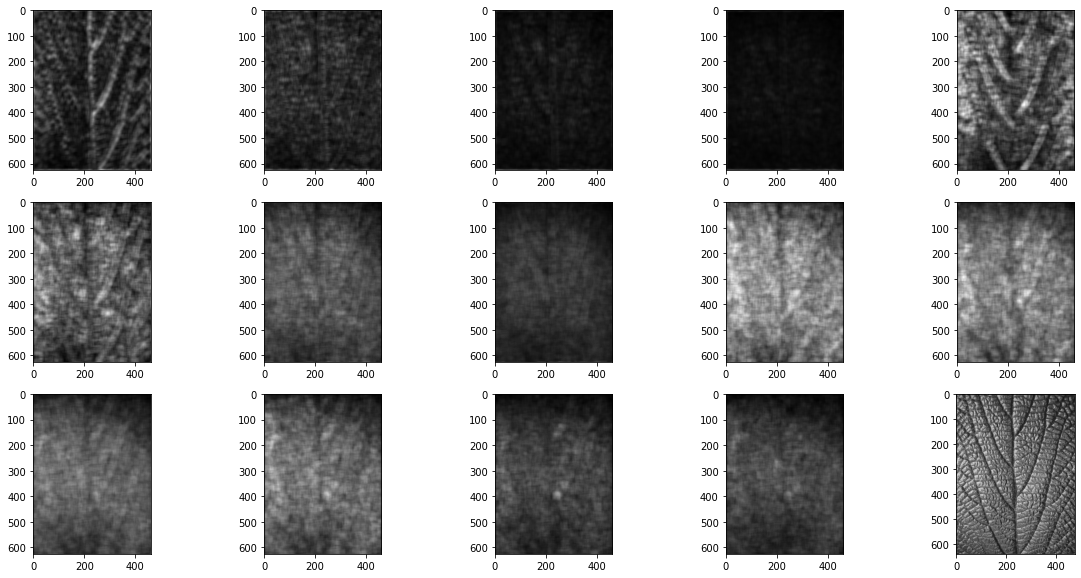

In [13]:
# np.random.seed(0)
random_img = np.random.choice(list(trainset.keys()))

img = trainset[random_img]["image"]
maps = laws.get_features(img, preprocess = True, merge_symmetric = True, compute_energy = True)

rows = 5
cols = 3
fig, axs = plt.subplots(cols, rows, figsize=(20, 10))

for i in range(cols):
    for j in range(rows):
        index = i*rows+j
        if index == 14:
            axs[i,j].imshow(img, cmap = "gray")
        else:
            axs[i,j].imshow(maps[...,index], cmap = "gray")
plt.show()

In [5]:
maps[...,0].min(), maps[...,0].max()

(7025.91999999996, 232284.5288888888)